# MOwNiT 

## Laboratorium 4

### Interpolacja

Przed uruchomieniem trzeba zainstalować pakiet:

```julia
Pkg.add("Interpolations")
```

In [1]:
#using Pkg
#Pkg.add("Interpolations")

In [2]:
using Plots

In [3]:
# wylosowanie węzłów interpolacji
xs =  1:1:10
ys = [rand() for x in xs]

10-element Vector{Float64}:
 0.7618394547089312
 0.9826646167000626
 0.9093911819202177
 0.5837346922801345
 0.41427935482595046
 0.8723229759260411
 0.10180023393891469
 0.010221750852874245
 0.675760567184747
 0.8936940974913269

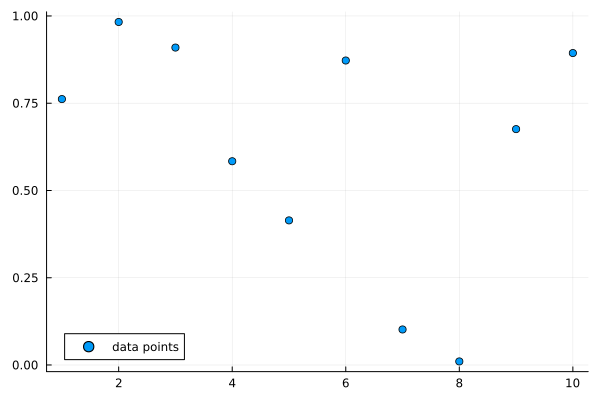

In [4]:
scatter(xs,ys, label="data points")

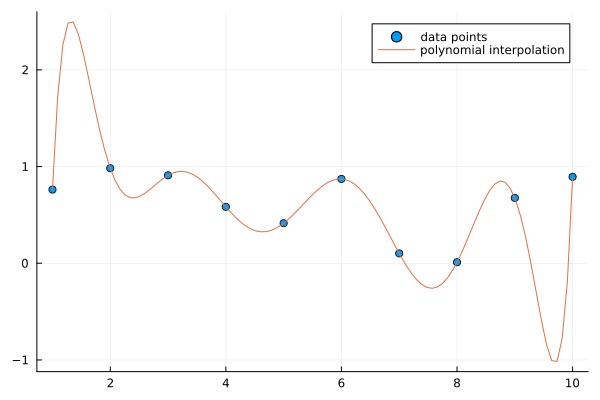

In [5]:
# interpolacja wielomianowa w pakiecie Polynomials
# https://juliamath.github.io/Polynomials.jl/stable/
#import Pkg; Pkg.add("Polynomials")
using Polynomials
f=fit(xs, ys)
plot!(f,  extrema(xs)..., label="polynomial interpolation")

In [6]:
# gęste punkty do rysowania wykresów funkcji interpolujacych
xsf=1:0.01:10

1.0:0.01:10.0

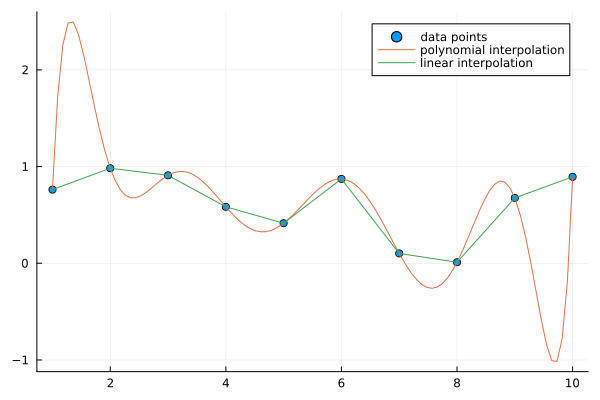

In [7]:
#  interpolacja liniowa z pakietu Interpolations - przykład
using Interpolations
interp_linear = LinearInterpolation(xs, ys)
ysf=[interp_linear(x) for x in xsf]
plot!(xsf,ysf, label="linear interpolation")

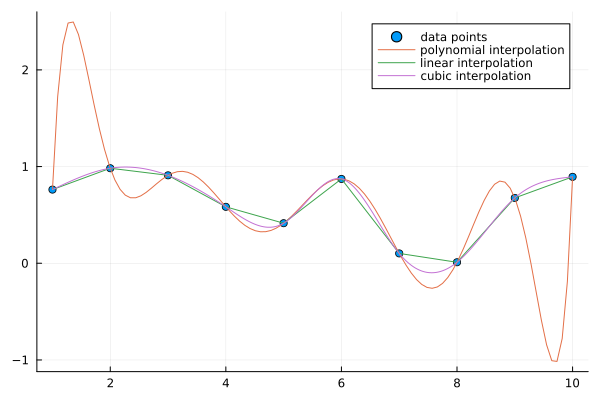

In [8]:
#  interpolacja szescienna 
interp_cubic = CubicSplineInterpolation(xs, ys)
ysf2=[interp_cubic(x) for x in xsf]
plot!(xsf,ysf2, label="cubic interpolation")

In [9]:
#Interpolacja szescienna to BSpline z warunkami brzegowymi Line i OnGrid. 
#Więcej o konfiguracji warunkow brzegowych w
# dokumentacji https://github.com/JuliaMath/Interpolations.jl/blob/master/doc/Interpolations_algebra.pdf
interp_cubic

10-element extrapolate(scale(interpolate(OffsetArray(::Vector{Float64}, 0:11), BSpline(Cubic(Line(OnGrid())))), (1:1:10,)), Throw()) with element type Float64:
 0.7618394547089312
 0.9826646167000627
 0.9093911819202177
 0.5837346922801344
 0.41427935482595046
 0.8723229759260412
 0.10180023393891466
 0.010221750852874217
 0.6757605671847471
 0.893694097491327

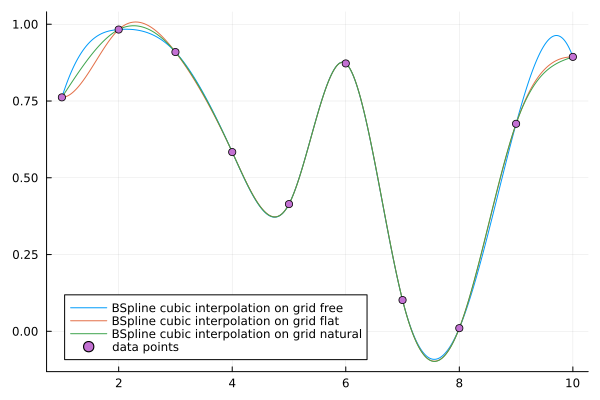

In [10]:
# Przyklad konfiguracji  BSpline-ów
itp = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot(xsf,ysf3, label="BSpline cubic interpolation on grid free")
itp = interpolate(ys, BSpline(Cubic(Flat(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline cubic interpolation on grid flat")
itp = interpolate(ys, BSpline(Cubic(Natural(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline cubic interpolation on grid natural")

scatter!(xs,ys, label="data points")


### Zadania
1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

1. Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

1. Zastosować interpolację wielomianową z pakietu Polynomials do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

1. Porównać metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonać pomiaru 10 razy i policzyć wartość średnią oraz oszacować błąd pomiaru za pomocą odchylenia standardowego; wyniki przedstawić na wykresach. <b>(2 pkt)</b>

1. Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

1. Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 

In [ ]:
#zad 1,2,3,5
using Plots
using Random
using CSV
using DataFrames
using Polynomials

# Funkcja do obliczania wartości wielomianu interpolacyjnego Lagrange'a
function lagrange_interpolation(x_vals, y_vals, x)
    n = length(x_vals)
    L = zeros(length(x))
    
    for i in 1:n
        li = ones(length(x))
        for j in 1:n
            if i != j
                li .*= (x .- x_vals[j]) / (x_vals[i] - x_vals[j])
            end
        end
        L .+= y_vals[i] * li
    end
    return L
end

# Funkcja do obliczania ilorazów różnicowych dla interpolacji Newtona
function newton_divided_differences(x_vals, y_vals)
    n = length(x_vals)
    coef = copy(y_vals)
    for j in 2:n
        for i in n:-1:j
            coef[i] = (coef[i] - coef[i-1]) / (x_vals[i] - x_vals[i-j+1])
        end
    end
    return coef
end

# Funkcja do obliczania wartości wielomianu Newtona (schemat Hornera)
function newton_interpolation(newt, x_vals, x)
    n = length(newt)
    p = newt[n]
    for i in (n-1):-1:1
        p = p .* (x .- x_vals[i]) .+ newt[i]
    end
    return p
end

# Algorytm Neville'a zmodyfikowany do pracy z pojedynczym punktem
function neville_point(x_vals, y_vals, x_point)
    n = length(x_vals)
    p = copy(y_vals)  # Inicjalizacja tablicy wartościami funkcji
    
    for k in 1:n-1
        for i in 1:n-k
            p[i] = ((x_point - x_vals[i+k]) * p[i] - (x_point - x_vals[i]) * p[i+1]) / 
                   (x_vals[i] - x_vals[i+k])
        end
    end
    
    return p[1]  # Wartość wielomianu interpolacyjnego w punkcie x_point
end

# Funkcja wektoryzująca obliczanie interpolacji Neville'a dla wielu punktów
function neville_interpolation(x_vals, y_vals, x)
    result = zeros(length(x))
    for i in 1:length(x)
        result[i] = neville_point(x_vals, y_vals, x[i])
    end
    return result
end

# Parametry
Random.seed!(420)  # Ustalamy ziarno losowości dla powtarzalności
n = 20  # Liczba węzłów
x_range = (-10, 10)  # Przedział interpolacji

# Losowe węzły interpolacji
x_vals = sort(rand(n) .* (x_range[2] - x_range[1]) .+ x_range[1])
y_vals = cos.(x_vals)  # Przykładowa funkcja do interpolacji

# Punkty do rysowania wykresu
x_plot = range(x_range[1], x_range[2], length=1000)

# Interpolacja Lagrange'a
y_lagrange = lagrange_interpolation(x_vals, y_vals, x_plot)

# Interpolacja Newtona
newt_coef = newton_divided_differences(x_vals, y_vals)
y_newton = newton_interpolation(newt_coef, x_vals, x_plot)

# Interpolacja Neville'a
y_neville = neville_interpolation(x_vals, y_vals, x_plot)

# Obliczenie wielomianu interpolacyjnego w postaci standardowej (Polynomials)
p_poly = fit(Polynomial, x_vals, y_vals)  # interpolacja wielomianowa z pakietu Polynomials
polynomials_coeffs = p_poly.coeffs         # współczynniki wielomianu

# Przyjmujemy, że współczynniki Newtona są zadane przez newt_coef,
exponents = 0:(n-1)
# Tworzymy DataFrame z trzema kolumnami: Newton, Lagrange i Polynomials (przyjmujemy, że Lagrange i Polynomials są równoważne)
df_poly = DataFrame(Potęga = exponents, 
                    Newton = newt_coef, 
                    #Lagrange = lagrange_coeffs, 
                    Polynomials = polynomials_coeffs)

# Zapis do pliku CSV
CSV.write("interpolation_polynomial_coefficients.csv", df_poly)

# Obliczenie wartości wielomianu z pakietu Polynomials dla wykresu
y_poly = p_poly.(x_plot)

# Rysowanie wykresów dla trzech metod interpolacji
plot(x_plot, y_lagrange, label="Interpolacja Lagrange'a (ręcznie)", linewidth=2, linestyle=:dash)
plot!(x_plot, y_newton, label="Interpolacja Newtona (ręcznie)", linewidth=2, linestyle=:solid)
plot!(x_plot, y_poly, label="Interpolacja Polynomials", linewidth=2, linestyle=:dot)
scatter!(x_vals, y_vals, label="Węzły interpolacji", markersize=5, color=:red)

# Zapis wykresu do pliku
savefig("interpolation_comparison.png")

# Obliczenie różnic między metodami interpolacji
diff_lagrange_poly = y_lagrange .- y_poly
diff_newton_poly   = y_newton   .- y_poly
diff_neville_poly  = y_neville  .- y_poly

# Dodaj małą wartość epsilon do różnic, aby uniknąć logarytmowania zera
eps = 1e-16  # wartość zbliżona do granicy dokładności maszynowej

# Rysowanie wykresu różnic z logarytmiczną skalą osi y
plot(x_plot, abs.(diff_lagrange_poly) .+ eps, label="|y_lagrange - y_poly|", linewidth=2, linestyle=:dash, yscale=:log10)
plot!(x_plot, abs.(diff_newton_poly) .+ eps, label="|y_newton - y_poly|", linewidth=2, linestyle=:solid, yscale=:log10)
plot!(x_plot, abs.(diff_neville_poly) .+ eps, label="|y_neville - y_poly|", linewidth=2, linestyle=:dot, yscale=:log10)
xlabel!("x")
ylabel!("Różnica (log10)")
title!("Różnice między interpolacjami (skala logarytmiczna)")
hline!([1e-16], linestyle=:dot, color=:black, label="Granica precyzji")  # linia odniesienia
savefig("interpolation_diff_log.png")


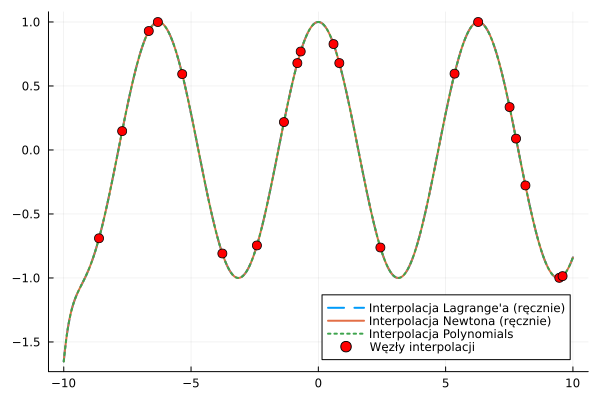
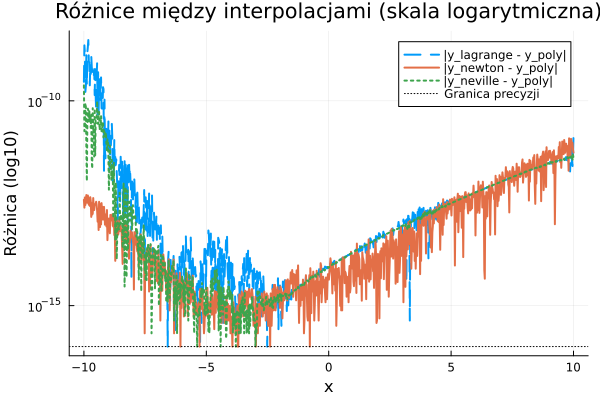


In [ ]:
Potęga,Newton,Polynomials
0,-0.6899547628711082,0.9999999727378903
1,0.9208196165827132,-1.4622987959400646e-8
2,-0.08828985199754016,-0.49999988057927286
3,-0.13196156030264974,7.722844266866424e-8
4,0.029983648276630154,0.04166652715593436
5,0.0008625071458060459,-9.891912357978816e-8
6,-0.0009755275292031528,-0.0013888527947611222
7,0.00012083363027389812,2.673528083665358e-8
8,1.2691343565258583e-6,2.479768353821629e-5
9,-1.8053476501596915e-6,-2.787502399909644e-9
10,1.341085313816717e-7,-2.753021387346908e-7
11,6.124240476563457e-9,1.4716012609952463e-10
12,-1.355888743810136e-9,2.074727826661025e-9
13,5.885914230531968e-11,-4.33857457468276e-12
14,2.041969959543587e-12,-1.107123170754256e-11
15,-3.728916581050099e-13,7.234984617100957e-14
16,1.6054333324693635e-14,4.033875110521279e-14
17,3.6639884291349674e-16,-6.367940508099691e-16
18,-6.706308179357597e-17,-7.779756878396657e-17
19,2.293558046832036e-18,2.293558046832036e-18

In [ ]:
#zad 4

using Plots
using Statistics
using Random
using Polynomials

# Upewnij się, że funkcje lagrange_interpolation, newton_divided_differences i newton_interpolation
# są już zdefiniowane (np. przez include("zad1_2_3.jl"))

# Definicje zakresu badanych liczby węzłów i liczby iteracji pomiarów
nvals = collect(100:100:1000)
num_iter = 10
x_range = (-5, 5)
x_eval = 1.0  # punkt ewaluacji

# Tablice na wyniki: średnie i std (dla poszczególnych rodzajów pomiarów)
lagrange_eval_means = Float64[]
lagrange_eval_stds  = Float64[]

newton_coeff_means = Float64[]
newton_coeff_stds  = Float64[]

newton_eval_means = Float64[]
newton_eval_stds  = Float64[]

poly_fit_means = Float64[]
poly_fit_stds  = Float64[]

poly_eval_means = Float64[]
poly_eval_stds  = Float64[]

# Dla każdej liczby węzłów wykonujemy num_iter pomiarów
for n in nvals
    times_lagrange = Float64[]
    times_newton_coeff = Float64[]
    times_newton_eval  = Float64[]
    times_poly_fit   = Float64[]
    times_poly_eval  = Float64[]
    
    for iter in 1:num_iter
        # Generujemy losowe węzły
        local x_vals = sort(rand(n) .* (x_range[2] - x_range[1]) .+ x_range[1])
        local y_vals = cos.(x_vals)
        
        # Pomiar: Lagrange - ewaluacja wartości interpolacji w punkcie x_eval
        t_lagrange = @elapsed begin
            y_lag = lagrange_interpolation(x_vals, y_vals, [x_eval])
        end
        push!(times_lagrange, t_lagrange)
        
        # Pomiar: Newton - obliczenie współczynników
        t_newton_coeff = @elapsed begin
            local newt_coef = newton_divided_differences(x_vals, y_vals)
        end
        push!(times_newton_coeff, t_newton_coeff)
        # Pomiar: Newton - ewaluacja wielomianu w punkcie x_eval
        t_newton_eval = @elapsed begin
            y_newt = newton_interpolation(newt_coef, x_vals, [x_eval])
        end
        push!(times_newton_eval, t_newton_eval)
        
        # Pomiar: Polynomials - dopasowanie (fit)
        t_poly_fit = @elapsed begin
            local p_poly = fit(Polynomial, x_vals, y_vals)
        end
        push!(times_poly_fit, t_poly_fit)
        # Pomiar: Polynomials - ewaluacja wielomianu w punkcie x_eval
        # Używamy wcześniej dopasowanego wielomianu
        local p_poly = fit(Polynomial, x_vals, y_vals)
        t_poly_eval = @elapsed begin
            y_pol = p_poly(x_eval)  # Użyj pojedynczej wartości, nie wektora
        end
        push!(times_poly_eval, t_poly_eval)        
    end
    
    push!(lagrange_eval_means, mean(times_lagrange))
    push!(lagrange_eval_stds, std(times_lagrange))
    
    push!(newton_coeff_means, mean(times_newton_coeff))
    push!(newton_coeff_stds, std(times_newton_coeff))
    
    push!(newton_eval_means, mean(times_newton_eval))
    push!(newton_eval_stds, std(times_newton_eval))
    
    push!(poly_fit_means, mean(times_poly_fit))
    push!(poly_fit_stds, std(times_poly_fit))
    
    push!(poly_eval_means, mean(times_poly_eval))
    push!(poly_eval_stds, std(times_poly_eval))
end

# Wykres 1: Czas EWALUACJI interpolacji (wartość w punkcie)
plot(nvals, lagrange_eval_means, yerror=lagrange_eval_stds, marker=:circle, label="Lagrange Eval")
plot!(nvals, newton_eval_means,   yerror=newton_eval_stds,   marker=:square, label="Newton Eval")
plot!(nvals, poly_eval_means,       yerror=poly_eval_stds,       marker=:diamond, label="Polynomials Eval")
xlabel!("Liczba węzłów")
ylabel!("Czas ewaluacji [s]")
title!("Porównanie czasu ewaluacji interpolacji")
savefig("evaluation_times.png")

# Wykres 2: Czas OBLICZENIA wielomianu (tylko metody, które to wyliczają osobno)
plot(nvals, newton_coeff_means, yerror=newton_coeff_stds, marker=:circle, label="Newton Coeff")
plot!(nvals, poly_fit_means,      yerror=poly_fit_stds,      marker=:square, label="Polynomials Fit")
xlabel!("Liczba węzłów")
ylabel!("Czas obliczenia wielomianu [s]")
title!("Porównanie czasu obliczenia wielomianu")
savefig("coeff_computation_times.png")



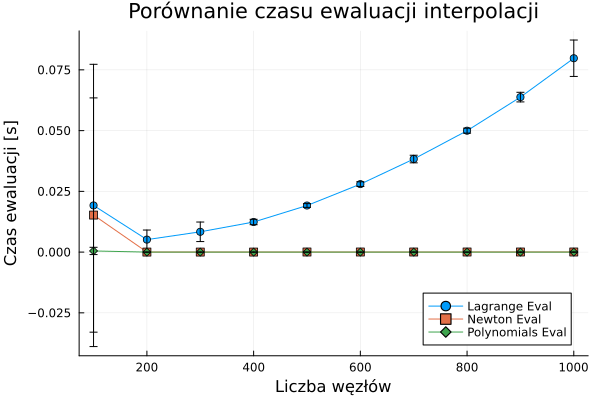
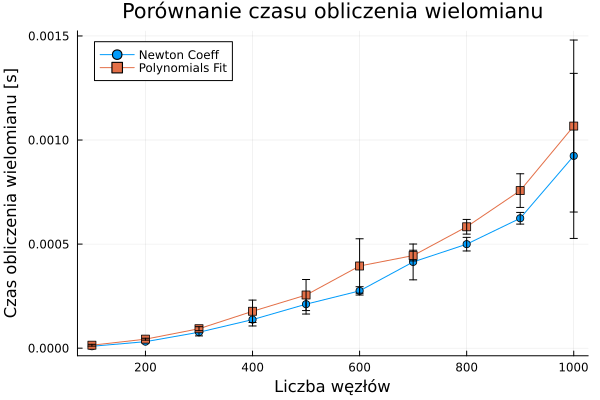

In [ ]:
#zad 6

using Plots
using Interpolations
using Polynomials

# Definicja funkcji Rungego
f(x) = 1/(1+25*x^2)

# Liczba punktów interpolacyjnych
n = 21
xs = LinRange(-1, 1, n)    # Changed: removed collect()
ys = f.(xs)

# Interpolacja funkcją składaną liniową
linear_itp = LinearInterpolation(xs, ys)

# Interpolacja funkcją składaną sześcienną (splajn naturalny)
cubic_itp = CubicSplineInterpolation(xs, ys)

# Interpolacja wielomianowa (stopień n-1)
p = fit(xs, ys, n-1)

# Punkty do rysowania wykresów
x_dense = LinRange(-1, 1, 500)
y_true    = f.(x_dense)
y_linear  = [linear_itp(x) for x in x_dense]
y_cubic   = [cubic_itp(x) for x in x_dense]
y_poly    = p.(x_dense)

# Rysowanie wykresów
plot(x_dense, y_true, lw=3, label="Funkcja Rungego", legend=:topright)
plot!(x_dense, y_linear, lw=2, ls=:dash, label="Sklejane liniowe")
plot!(x_dense, y_cubic, lw=2, ls=:dot, label="Sklejane sześcienne")
plot!(x_dense, y_poly, lw=2, ls=:dashdot, label="Interpolacja wielomianowa")
xlabel!("x")
ylabel!("f(x)")
title!("Porównanie interpolacji (efekt Rungego)")
savefig("zad6_1.png")

plot(x_dense, y_true, lw=3, label="Funkcja Rungego", legend=:topright)
plot!(x_dense, y_linear, lw=2, ls=:dash, label="Sklejane liniowe")
plot!(x_dense, y_cubic, lw=2, ls=:dot, label="Sklejane sześcienne")
xlabel!("x")
ylabel!("f(x)")
title!("Porównanie interpolacji liniowej i sześciennej")
savefig("zad6_2.png")

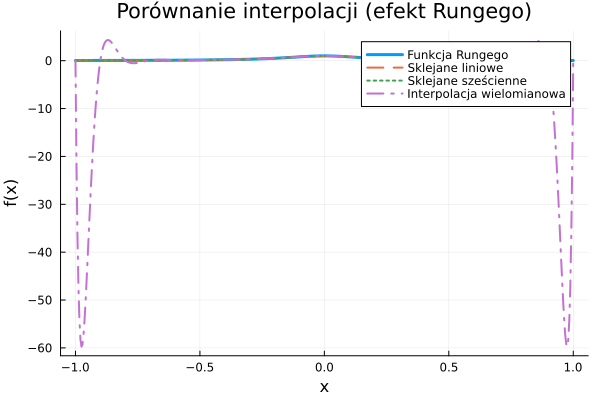
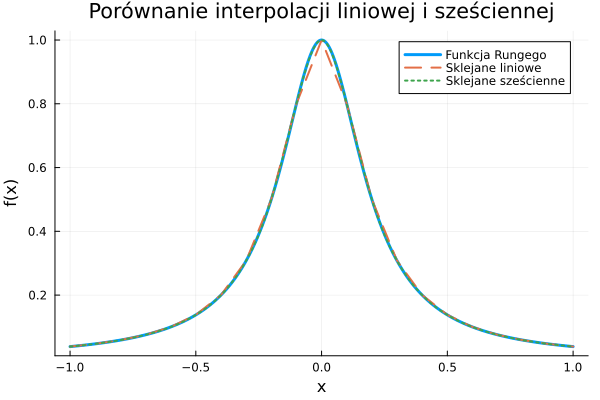